In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset_full = datasets.MNIST(root='mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist', train=False, download=True, transform=transform)


train_size = 50_000
val_size = 10_000
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

print("Размер обучающей выборки:", len(train_dataset))
print("Размер валидационной выборки:", len(val_dataset))
print("Размер тестовой выборки:", len(test_dataset))


Размер обучающей выборки: 50000
Размер валидационной выборки: 10000
Размер тестовой выборки: 10000


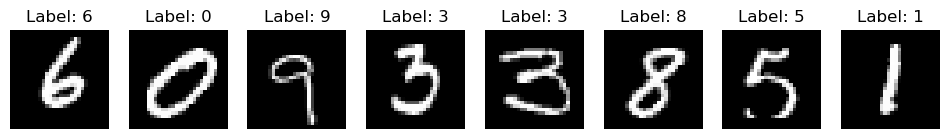

In [3]:
BATCH_SIZE = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE)


plt.figure(figsize=(12, 3))
for i in range(8):
    img, label = train_dataset[i]
    img = img.squeeze(0)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x



class DropoutBatchnormNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)

        self.linear2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)

        self.linear3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = F.relu(self.bn1(self.linear1(x)))
        x = self.drop1(x)

        x = F.relu(self.bn2(self.linear2(x)))
        x = self.drop2(x)

        x = self.linear3(x)
        return x

In [8]:
def train_one_epoch(model, optimizer, loss_fn, train_loader, device):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        logits = model(X)
        loss = loss_fn(logits, y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, loss_fn, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item()
    return total_loss / len(val_loader)



def plot_history(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.yscale('log')
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


Используемое устройство: cpu

--- Эксперимент с моделью simple_nn ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------
Эпоха [2/10] -> train_loss: 0.1882, val_loss: 0.1459
Эпоха [4/10] -> train_loss: 0.1073, val_loss: 0.1040
Эпоха [6/10] -> train_loss: 0.0761, val_loss: 0.0963
Эпоха [8/10] -> train_loss: 0.0601, val_loss: 0.0709
Эпоха [10/10] ->

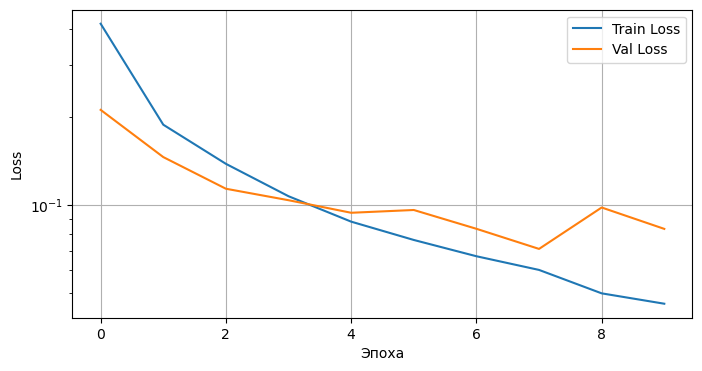


--- Эксперимент с моделью dropout_batchnorm_nn ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.05
Estimated Total Size (MB): 2.08
-------------------------------------------------------

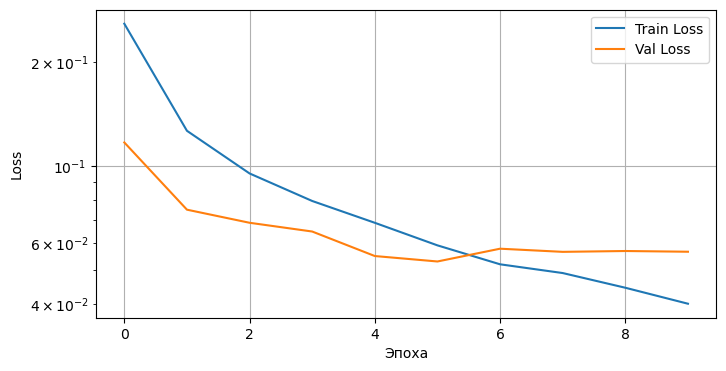

In [ ]:
# Ускорим обучение с помощью GPU

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используемое устройство:", device)

models_to_try = {
    "simple_nn": SimpleNN(),
    "dropout_batchnorm_nn": DropoutBatchnormNN()
}

EPOCHS = 10

results_table = []

for model_name, model in models_to_try.items():
    print(f"\n--- Эксперимент с моделью {model_name} ---")
    model.to(device)

    summary(model, (1, 28, 28))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, optimizer, loss_fn, train_loader, device)
        val_loss   = evaluate(model, loss_fn, val_loader, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 2 == 0:
            print(f"Эпоха [{epoch+1}/{EPOCHS}] -> train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    
    plot_history(train_losses, val_losses)
    
    min_val_loss = min(val_losses)
    
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    results_table.append({
        "Модель": model_name,
        "min_val_loss": round(min_val_loss, 4),
        "accuracy_test": round(accuracy, 4),
        "precision_test (macro)": round(precision, 4),
        "recall_test (macro)": round(recall, 4),
        "f1_test (macro)": round(f1, 4)
    })


In [11]:
import pandas as pd

df_results = pd.DataFrame(results_table)


In [13]:
print("Таблица результатов:\n")
display(df_results)

print("Было построено 2 модели: обычная нейронная сеть и нейронная сеть с BatchNorm и Dropout.")
print("У первой модели было замечено начало переобучения на 5 эпохе.")
print("Обе модели сошлись и показали выскую точность (около 98%).")
print("Двухслойная (первая) нейросеть показала результат несущественно хуже, чем трехслойная, не считая BatchNorm и Dropout.")
print("На представленных данных модель с BatchNorm и Dropout показала себя чуть лучше, чем обычная нейронная сеть, однако, прирост в точности несущественнен.")



Таблица результатов:



,Модель,min_val_loss,accuracy_test,precision_test (macro),recall_test (macro),f1_test (macro)
0,simple_nn,0.0709,0.9735,0.9735,0.9734,0.9733
1,dropout_batchnorm_nn,0.0530,0.9799,0.9798,0.9799,0.9798


Было построено 2 модели: обычная нейронная сеть и нейронная сеть с BatchNorm и Dropout.
У первой модели было замечено начало переобучения на 5 эпохе.
Обе модели сошлись и показали выскую точность (около 98%).
Двухслойная (первая) нейросеть показала результат несущественно хуже, чем трехслойная, не считая BatchNorm и Dropout.
На представленных данных модель с BatchNorm и Dropout показала себя чуть лучше, чем обычная нейронная сеть, однако, прирост в точности несущественнен.
